FileName: initial_model_development.ipynb

Developer: Tanmoy Das
Date: June 11, 2023

Outline of this script:
1. model1
2. model2

Both models are implemented in following steps:
1. Input data
2. Optimization Model
3. Output in a form of Network Diagram

# Data

## Data importing

In [1]:
# import custom functions
import data_preparation
import custom_func
import model
import model_analysis
# import libraries
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
# Import data
spill_data = pd.read_excel('Inputs/data_100_oil_spills.xlsx', sheet_name='spills', header=0).copy()
station_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='stations', header=0).copy()
input_parameters = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='Estimated parameters', header=0).copy()
sensitivity_dataR = gpd.read_file('Inputs/ArcGIS_data/Sensitivity_data/Sensitivity_data5.shp').copy()
# spill_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='spills', header=0).copy()
# spill_data = spill_data.sample(n=100)

In [3]:
spill_data.head()
display(station_data)

,no.,Station #,Station,Name,Coordinates,skimmers,booms,dispersant,burning,Resources total,Converted resources,Capacity,Unnamed: 12,Unnamed: 13
0,1,s1,Station 1,Beafort sea,"(70,-134)",0,1,33,NaN,34,NaN,0,NaN,NaN
1,2,s2,Station 2,Northwestern passage,"(70.64, -119.43)",8,8,55,NaN,71,NaN,80,NaN,NaN
2,3,s3,Station 3,Kitikmeot Region,"(67.09, -112.32)",1,4,58,NaN,63,NaN,80,NaN,NaN
3,4,s4,Station 4,Fort Smith,"(62.60, -113.19)",10,3,32,NaN,45,NaN,80,NaN,NaN
4,5,s5,Station 5,Hay River,"(60.53, -114.38)",40,10,100,NaN,150,NaN,0,NaN,NaN
5,6,s6,Station 6,NaN,"(68.86,-103.19)",10,3,44,NaN,57,NaN,80,NaN,"(60.758054, -115.789890)"
6,7,s7,Station 7,NaN,"(63.93, -101.14)",0,3,47,NaN,50,NaN,80,NaN,"(58.55084,-93.62352)"
7,8,s8,Station 8,NaN,"(60.06, -95.89)",3,5,58,NaN,66,NaN,80,NaN,"(69.459, -132.974304)"
8,9,s9,Station 9,NaN,"(75.11, -95.71)",5,7,59,NaN,71,NaN,80,NaN,"(63.742885, -68.464958)"
9,10,s10,Station 10,Kivalliq Region,"(63.03, -91.74)",4,9,36,NaN,49,NaN,80,NaN,NaN


## Data Preprocessing

In [4]:
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(station_data, spill_data, input_parameters)
coordinates_spill = custom_func.extract_spill_coordinate(spill_data)
coordinates_st = custom_func.extract_station_coordinate(station_data)

SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20']


In [5]:
# normalize  # (x_0-x_min)/(x_max-x_min)
SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))
Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

## Scalar inputs of the models

In [6]:
DistanceMax = 10
BigM = 10**20
current_vs_proposed = 'proposed' # current
MaxFO = 1
Budget = 10**12
W = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
QuantityMin = 2

# Model Configuration 1

In [7]:
NumberStMax_m1 = 4

## Run the optimization model

In [8]:
model01, select, deploy, mvars, names, values, objValues, \
        spill_df, station_df, cover_1s, select_1s, deploy_1s, MeanResponseTime, coverage_percentage, assignment  \
    = model.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m1, Distance, Distance_n,
          W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
          BigM, MaxFO)

len of OilSpills:  100
--------------MIP-moo--------
Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-04
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "Outputs/Logfiles/model_moo(Jul 14,1627).log"
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1832 rows, 1436 columns and 4534 nonzeros
Model fingerprint: 0x994e751b
Variable types: 1062 continuous, 374 integer (374 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+25]
  Objective range  [1e-02, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

-------------------------------------------------------------

## Network Diagram

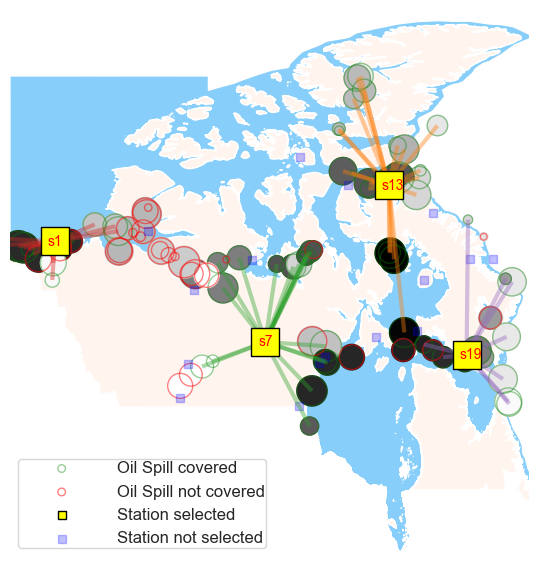

In [9]:
# Draw Network Diagram
assignment_line_m1 = model_analysis.draw_network_diagram(DistanceMax, NumberStMax_m1, Sensitivity_R, spill_df, station_df, MeanResponseTime, coverage_percentage, assignment, deploy_1s, select_1s, current_vs_proposed)

## Inputs & Outputs

In [10]:
input_output_df = pd.DataFrame(index=range(1), columns=['Max no of stations', 'Max distance','Coverage Percentage', 'Mean Response Time', 'Objective 1', 'Objective 2'])
input_output_df.iloc[0,0] = NumberStMax_m1
input_output_df.iloc[0,1] = DistanceMax
input_output_df.iloc[0,2] = coverage_percentage
input_output_df.iloc[0,3] = MeanResponseTime
input_output_df.iloc[0,4] = objValues[0::2][1]
input_output_df.iloc[0,5] = objValues[1::2][1]
input_output_df

,Max no of stations,Max distance,Coverage Percentage,Mean Response Time,Objective 1,Objective 2
0,4,10,78,7.9,1006.00302,525.0


## Resource allocation from facilities (Table 5)

In [11]:
assignment_line_m1 = pd.DataFrame(columns=list(assignment.columns.values))
for i, o in enumerate(assignment['Spill #'].unique()):
    minD = min(assignment.loc[assignment['Spill #'] == o]['Distance'])
    df = assignment.iloc[np.where(assignment['Distance'] == minD)[0]]
    assignment_line_m1 = pd.concat([assignment_line_m1, df])

resource_allocation_m1 = assignment_line_m1[['Station no.', 'Resource Type', 'Quantity deployed']]
resource_allocation_m1 = resource_allocation_m1.sort_values(by=['Station no.'])
resource_allocation_m1 = resource_allocation_m1.groupby(['Station no.', 'Resource Type'])['Quantity deployed'].mean().reset_index()
resource_allocation_m1['Facility'] = 'Proposed'
resource_allocation_m1

,Station no.,Resource Type,Quantity deployed,Facility
0,s1,c,31.142857,Proposed
1,s1,i,62.714286,Proposed
2,s13,c,52.200000,Proposed
3,s13,i,57.000000,Proposed
4,s13,m,36.800000,Proposed
5,s19,c,57.400000,Proposed
6,s19,i,62.714286,Proposed
7,s7,c,57.454545,Proposed
8,s7,i,22.000000,Proposed


# Model Configuration 2

In [12]:
NumberStMax_m2 = 8

In [13]:
model02, select_m2, deploy_m2, mvars_m2, names_m2, values_m2, objValues_m2, \
        spill_df_m2, station_df_m2, cover_1s_m2, select_1s_m2, deploy_1s_m2, MeanResponseTime_m2, coverage_percentage_m2, assignment_m2  \
    = model.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m2, Distance, Distance_n,
          W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
          BigM, MaxFO)

len of OilSpills:  100
--------------MIP-moo--------
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "Outputs/Logfiles/model_moo(Jul 14,1627).log"
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1832 rows, 1436 columns and 4534 nonzeros
Model fingerprint: 0x6ded4a9b
Variable types: 1062 continuous, 374 integer (374 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+25]
  Objective range  [1e-02, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
-------------

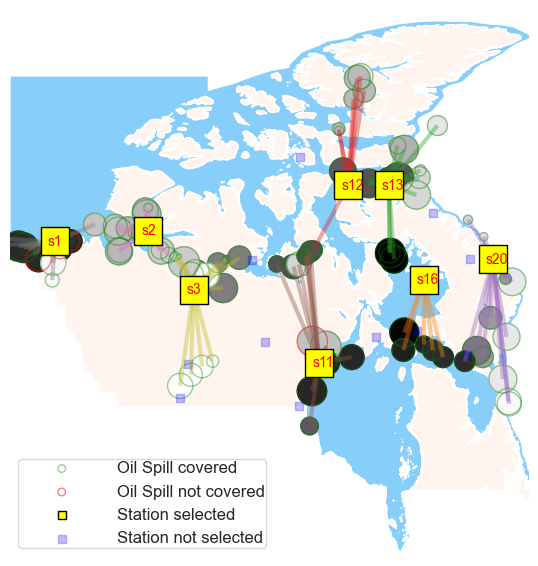

,Spill #,Station no.,St_Latitude,St_Longitude,Spill_Latitude,Spill_Longitude,Resource Type,Quantity deployed,Distance
1,o74,s16,67.669998,-76.379997,64.504219,-79.406021,m,20.0,4.379381
2,o98,s13,73.400002,-81.830002,73.858727,-77.062927,i,37.0,4.789095
4,o127,s13,73.400002,-81.830002,69.348618,-81.734749,m,2.0,4.052504
7,o51,s13,73.400002,-81.830002,73.861763,-82.001617,i,37.0,0.492621
11,o119,s12,73.400002,-88.160004,76.695244,-89.592224,c,110.0,3.593032
...,...,...,...,...,...,...,...,...,...
149,o184,s1,70.000000,-134.000000,70.117081,-131.620728,i,37.0,2.382151
150,o22,s1,70.000000,-134.000000,67.670395,-134.398529,c,110.0,2.363448
151,o198,s1,70.000000,-134.000000,70.399017,-131.880280,c,5.0,2.156949
152,o220,s1,70.000000,-134.000000,69.243050,-137.326294,c,31.0,3.411335


In [14]:
# Draw Network diagram
model_analysis.draw_network_diagram(DistanceMax, NumberStMax_m2, Sensitivity_R, spill_df_m2, station_df_m2, MeanResponseTime_m2, coverage_percentage_m2, assignment_m2, deploy_1s_m2, select_1s_m2, current_vs_proposed)

## Input & Output

In [15]:
input_output_df_m2 = pd.DataFrame(index=range(1), columns=['Max no of stations', 'Max distance (kms)', 'Coverage Percentage', 'Mean Response Time','Objective 1', 'Objective 2'])
input_output_df_m2.iloc[0,0] = NumberStMax_m2
input_output_df_m2.iloc[0,1] = DistanceMax
input_output_df_m2.iloc[0,4] = coverage_percentage_m2
input_output_df_m2.iloc[0,5] = MeanResponseTime_m2
input_output_df_m2.iloc[0,2] = objValues_m2[0::2][1]
input_output_df_m2.iloc[0,3] = objValues_m2[1::2][1]
input_output_df_m2

,Max no of stations,Max distance (kms),Coverage Percentage,Mean Response Time,Objective 1,Objective 2
0,8,10,1149.213936,-7904.943111,99,7.28


## 200 spills

In [ ]:
# spill_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='spills', header=0).copy()
# spill_data = spill_data.sample(n=200)
# spill_data.to_csv('Inputs/data_200_oil_spills.csv')
spill_data200 = pd.read_csv('Inputs/data_200_oil_spills.csv')


In [ ]:
# Spill data processing
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(station_data, spill_data, input_parameters)
coordinates_spill = custom_func.extract_spill_coordinate(spill_data)
coordinates_st = custom_func.extract_station_coordinate(station_data)

SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)


In [ ]:
# normalize  # (x_0-x_min)/(x_max-x_min)
SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))
Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))


In [ ]:
NumberStMaxL = [15, 12, 8, 5, 4, 2]
number_of_spillsL = [200, 200, 200, 200, 200, 200]
select_1sL =[]
coverage_percentageL =[]
MeanResponseTimeL =[]

In [ ]:
for i in range(len(NumberStMaxL)):
    model01, select, deploy, mvars, names, values, objValues, \
            spill_df, station_df, cover_1s, select_1s, deploy_1s, MeanResponseTime, coverage_percentage, assignment  \
        = model.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n,
              Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMaxL[i], Distance, Distance_n,
              W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
              BigM, MaxFO)
    select_1sL.append(select_1s.index)
    coverage_percentageL.append(coverage_percentage)
    MeanResponseTimeL.append(MeanResponseTime)


In [ ]:
determine_number_of_facilities = pd.DataFrame(index=range(len(NumberStMaxL)),
                                              columns=['Number of facilities', 'Number of spills','Open facility', 'Coverage (%)', 'Mean Response time (in hours)', 'Cost investment (in million CAD)'])
for i in range(6):
    determine_number_of_facilities.iloc[i,0] = NumberStMaxL[i]
    determine_number_of_facilities.iloc[i,1] = number_of_spillsL[i]
    determine_number_of_facilities.iloc[i,2] = select_1sL[i]
    determine_number_of_facilities.iloc[i,3] = coverage_percentageL[i]
    determine_number_of_facilities.iloc[i,4] = MeanResponseTimeL[i]
    determine_number_of_facilities.iloc[i,5] = 0
determine_number_of_facilities

## 100 Spills

In [ ]:
NumberStMaxL = [15, 12, 8, 5, 4, 2]
number_of_spillsL = [100, 100,100, 100,100, 100]
select_1sL =[]
coverage_percentageL =[]
MeanResponseTimeL =[]

In [ ]:
for i in range(6):
    model01, select, deploy, mvars, names, values, objValues, \
            spill_df, station_df, cover_1s, select_1s, deploy_1s, MeanResponseTime, coverage_percentage, assignment  \
        = model.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n,
              Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMaxL[i], Distance, Distance_n,
              W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
              BigM, MaxFO)
    select_1sL.append(select_1s.index)
    coverage_percentageL.append(coverage_percentage)
    MeanResponseTimeL.append(MeanResponseTime)


In [ ]:
determine_number_of_facilities = pd.DataFrame(index=range(6),
                                              columns=['Number of facilities', 'Number of spills','Open facility', 'Coverage (%)', 'Mean Response time (in hours)', 'Cost investment (in million CAD)'])
for i in range(6):
    determine_number_of_facilities.iloc[i,0] = NumberStMaxL[i]
    determine_number_of_facilities.iloc[i,1] = number_of_spillsL[i]
    determine_number_of_facilities.iloc[i,2] = select_1sL[i]
    determine_number_of_facilities.iloc[i,3] = coverage_percentageL[i]
    determine_number_of_facilities.iloc[i,4] = MeanResponseTimeL[i]
    determine_number_of_facilities.iloc[i,5] = 0
determine_number_of_facilities